## Librerías

In [1]:
# Libraries which will help us to manipulate a lil bit more our data
import numpy as np
import pandas as pd

# pandas: display all columns
pd.set_option('display.max_columns', None)

# Sklearn: Library for Train/Test Split // confusion matrix
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

# TensorFlow: Library for model training
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Matplotlib: Library for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Functions: Library which contains all the functions that we'll use
import functions as fn

# Functions: Library which contains all the visualizations that we'll plot
import visualizations as vz

# Display plotly graphs in HTML
import plotly.io as pio
pio.renderers.default='notebook'

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from collections import Counter

## Cargar datos

In [2]:
data= pd.read_parquet('Data_new_outliers.parquet')
data.drop(columns=["", "fraccion4", "Precio_raro", "articulo", "pais_origen_destino", "descripcion limpia", "descripcion", 
                   "TIGIE_D", "unidad_medida", "descripcion_unidad_medida", "codigo_pais", "continente"], inplace = True)

# Guardar en una variable el nombre de nuestra variable objetivo
target_variable ='outlier'

In [3]:
# Aplicar label encoder para castear texto a numérico
data = fn.label_encoder(data)

In [4]:
Counter(data["outlier"])

Counter({0: 887167, 1: 39122})

In [5]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

# Weights

In [6]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(data, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [7]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop(target_variable))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop(target_variable))
test_labels = np.array(test_df.pop(target_variable))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [8]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

$$w_j = \frac{n}{kn_j}$$

$\text{Where}$ \
$w_j: \ \text{is the weight to class j}$ \
$n: \ \text{is the number of observations}$ \
$n_j: \ \text{is the number of observations in class j, and}$ \
$k: \ \text{is the total number of classes.}$


In [9]:
unique_classes = [0, 1]

In [10]:
class_weight  = {}
for classes in unique_classes:
    class_weight[classes] = data.shape[0]/((data.loc[data[target_variable] == classes].shape[0])*len(unique_classes))

In [11]:
class_weight

{0: 0.5220488363521186, 1: 11.838466847298195}

In [12]:
EPOCHS = 10
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
weighted_model = make_model()

In [14]:
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/10
290/290 [==============================] - 2s 3ms/step - loss: 0.6200 - accuracy: 0.7897 - precision: 0.0991 - recall: 0.4932 - auc: 0.6982 - val_loss: 0.5012 - val_accuracy: 0.8675 - val_precision: 0.1785 - val_recall: 0.5963 - val_auc: 0.8402
Epoch 2/10
290/290 [==============================] - 1s 3ms/step - loss: 0.5251 - accuracy: 0.8458 - precision: 0.1573 - recall: 0.6107 - auc: 0.8206 - val_loss: 0.4635 - val_accuracy: 0.8844 - val_precision: 0.2203 - val_recall: 0.6872 - val_auc: 0.8945
Epoch 3/10
290/290 [==============================] - 1s 2ms/step - loss: 0.4817 - accuracy: 0.8726 - precision: 0.1987 - recall: 0.6674 - auc: 0.8669 - val_loss: 0.4383 - val_accuracy: 0.8931 - val_precision: 0.2422 - val_recall: 0.7234 - val_auc: 0.9104
Epoch 4/10
290/290 [==============================] - 1s 2ms/step - loss: 0.4585 - accuracy: 0.8796 - precision: 0.2159 - recall: 0.7060 - auc: 0.8863 - val_loss: 0.4194 - val_accuracy: 0.8969 - val_precision: 0.2537 - val_recall: 0

In [15]:
def plot_metrics(history):
    metrics = ['loss', 'precision', 'recall', 'auc']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.4,1])
        else:
            plt.ylim([0,1])

        plt.legend()

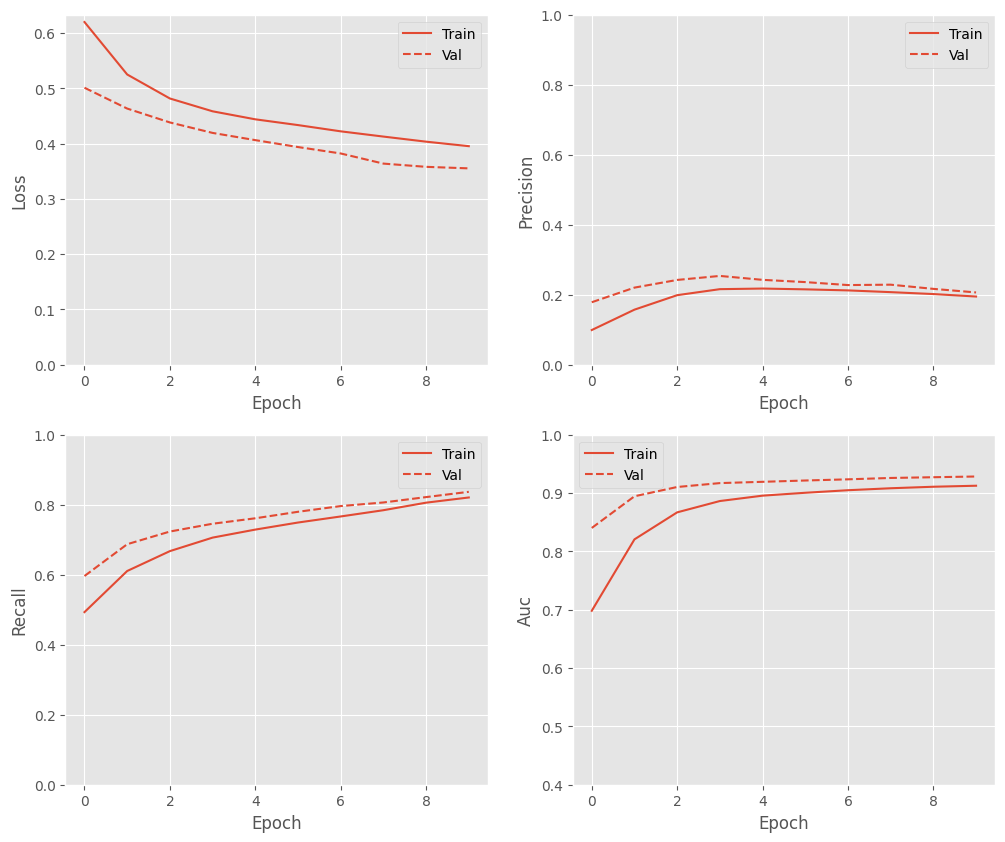

In [16]:
plot_metrics(weighted_history)

In [17]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

91/91 [==============================] - 0s 794us/step


In [18]:
def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(9, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate No-Outliers Detected (True Negatives): ', cm[0][0])
    print('Legitimate No-Outliers Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Outliers Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Outliers Detected (True Positives): ', cm[1][1])
    print('Total Outliers: ', np.sum(cm[1]))
    print('Total No-Outliers: ', np.sum(cm[0]))

Legitimate No-Outliers Detected (True Negatives):  152394
Legitimate No-Outliers Incorrectly Detected (False Positives):  24957
Fraudulent Outliers Missed (False Negatives):  1274
Fraudulent Outliers Detected (True Positives):  6633
Total Outliers:  7907
Total No-Outliers:  177351


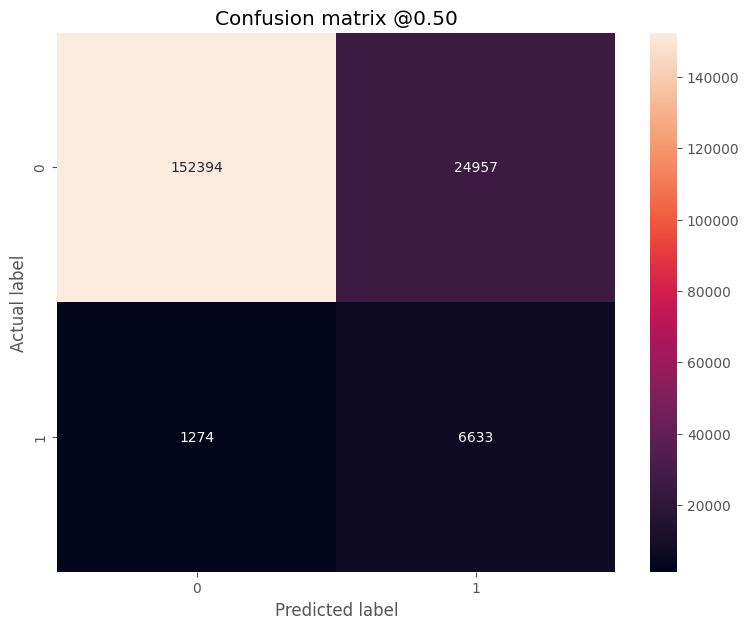

In [19]:
plot_cm(test_labels, test_predictions_weighted)

In [28]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', np.round(value, 2))

f1 = (2*weighted_results[2]*weighted_results[3])/(weighted_results[2]+weighted_results[3])
print("f1 : ", np.round(f1, 2))

loss :  0.36
accuracy :  0.86
precision :  0.21
recall :  0.84
auc :  0.93
f1 :  0.34
